In [1]:
%reload_ext autoreload
%autoreload 2

import pickle
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from azureml.core import Dataset, Workspace
from glob2 import glob
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

sys.path.append(str(Path(os.getcwd()).parent))
from data_utilities import find_outlier_qrcodes, convert_age_from_days_to_years, draw_age_distribution, calculate_code_age_distribution

In [2]:
# for pixel outliers
def get_qrcode(artifact:str) -> str:
    return artifact.split('_')[1]

def get_path(row: pd.Series) -> str:
    return f"{str(DATASET_PATH)}/scans/{row.qrcode}/{row.key}/{row.artifact}"

### Sample of the depthmap in a testset

In [3]:
DATASET_PATH = Path('/mnt/datasets/depthmap_testset')

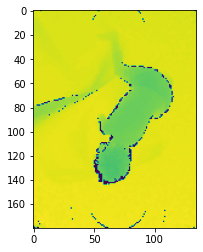

In [4]:
paths  = DATASET_PATH / 'scans/1585364002-gqyabdudft/202/pc_1585364002-gqyabdudft_1593018669176_202_016.p'
depthmap, targets = pickle.load(open(paths, "rb"))
_ = plt.imshow(np.squeeze(depthmap))

In [5]:
targets

array([90.7, 10.8])

### Read the csv files 

In [6]:
testdata = pd.read_csv(DATASET_PATH / 'labels/testing.csv')
testdata.head()

,artifact,qrcode,id,height,weight,key,age
0,pc_1585004725-18cqo1np0j_1592801845251_100_000.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479
1,pc_1585004725-18cqo1np0j_1592801845251_100_001.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479
2,pc_1585004725-18cqo1np0j_1592801845251_100_002.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479
3,pc_1585004725-18cqo1np0j_1592801845251_100_003.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479
4,pc_1585004725-18cqo1np0j_1592801845251_100_004.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479


In [7]:
artifacts = pd.read_csv(DATASET_PATH / 'labels/testing.csv')
print("Total no. of artifacts:", len(artifacts))
artifacts['Years'] = artifacts.apply(convert_age_from_days_to_years, axis=1)
artifacts.head()

Total no. of artifacts: 57272


,artifact,qrcode,id,height,weight,key,age,Years
0,pc_1585004725-18cqo1np0j_1592801845251_100_000.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
1,pc_1585004725-18cqo1np0j_1592801845251_100_001.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
2,pc_1585004725-18cqo1np0j_1592801845251_100_002.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
3,pc_1585004725-18cqo1np0j_1592801845251_100_003.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
4,pc_1585004725-18cqo1np0j_1592801845251_100_004.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4


### Number of the children in testset

In [8]:
scans = artifacts.drop_duplicates(subset='qrcode', keep='first').reset_index(drop=True)
print("Total no. of children:",len(scans))
scans.head()

Total no. of children: 1745


,artifact,qrcode,id,height,weight,key,age,Years
0,pc_1585004725-18cqo1np0j_1592801845251_100_000.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
1,pc_1585012629-ac1ippx2qy_1591848606827_100_000.p,1585012629-ac1ippx2qy,VTv17LBYYqrWXL6L_artifact-scan-pcd_15717024000...,87.3,10.90,100,973,2
2,pc_1585012645-ii2eyvdpib_1591848619397_100_000.p,1585012645-ii2eyvdpib,Akw83Kik8PTy6xrf_artifact-scan-pcd_15717024000...,103.1,13.95,100,487,1
3,pc_1585012682-ccfj5uwkr6_1591848647875_100_000.p,1585012682-ccfj5uwkr6,U55iJZJv0eWbuRl7_artifact-scan-pcd_15717024000...,90.9,11.15,100,1344,3
4,pc_1585012756-r5jc2vztha_1591848681729_100_000.p,1585012756-r5jc2vztha,Yn4u5mO2tsf9EUMA_artifact-scan-pcd_15717024000...,84.6,10.25,100,1145,3


### Converting the age from days to years

In [9]:
scans['Years'] = scans.apply(convert_age_from_days_to_years, axis=1)
scans.head()

,artifact,qrcode,id,height,weight,key,age,Years
0,pc_1585004725-18cqo1np0j_1592801845251_100_000.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4
1,pc_1585012629-ac1ippx2qy_1591848606827_100_000.p,1585012629-ac1ippx2qy,VTv17LBYYqrWXL6L_artifact-scan-pcd_15717024000...,87.3,10.90,100,973,2
2,pc_1585012645-ii2eyvdpib_1591848619397_100_000.p,1585012645-ii2eyvdpib,Akw83Kik8PTy6xrf_artifact-scan-pcd_15717024000...,103.1,13.95,100,487,1
3,pc_1585012682-ccfj5uwkr6_1591848647875_100_000.p,1585012682-ccfj5uwkr6,U55iJZJv0eWbuRl7_artifact-scan-pcd_15717024000...,90.9,11.15,100,1344,3
4,pc_1585012756-r5jc2vztha_1591848681729_100_000.p,1585012756-r5jc2vztha,Yn4u5mO2tsf9EUMA_artifact-scan-pcd_15717024000...,84.6,10.25,100,1145,3


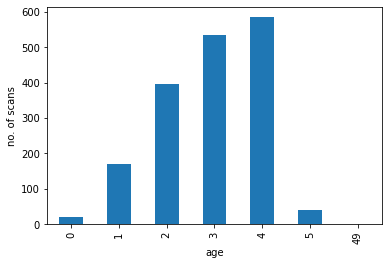

In [10]:
plt.figure()
draw_age_distribution(scans)
plt.show()

101    29281
102    14088
100    13778
200       67
201       41
202       17
Name: key, dtype: int64


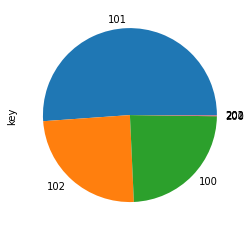

In [11]:
## keys for different scan type and their distribution in dataset
"- 100 - standing front scan",
"- 101 - standing 360 scan",
"- 102 - standing back scan",
"- 200 - lying front scan",
"- 201 - lying side scan",
"- 202 - lying back scan"
print(artifacts['key'].value_counts())
artifacts['key'].value_counts().plot(kind='pie')

In [12]:
calculate_code_age_distribution(artifacts)

,0,1,2,3,4
codes,,,,,
100,178,1296,3172,4212,4607
101,455,2274,6412,9631,9963
102,189,1594,3128,4267,4605
200,0,67,0,0,0
201,0,41,0,0,0
202,0,17,0,0,0


In [13]:
calculate_code_age_distribution(scans)

,0,1,2,3,4
codes,,,,,
100,19,169,397,533,584
101,0,0,0,1,1


### Distribution data based on height, weight and age

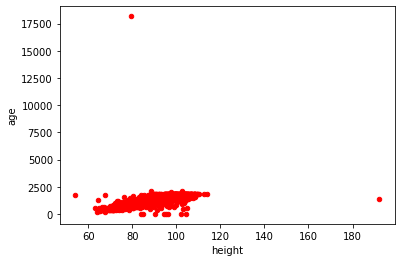

In [14]:
#distribution of height against age
height_vs_age = scans.plot.scatter(x='height', y='age', c='red')

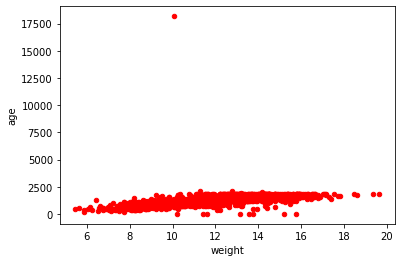

In [15]:
#distribution of weight against age
weight_vs_age = scans.plot.scatter(x='weight', y='age', c='red')

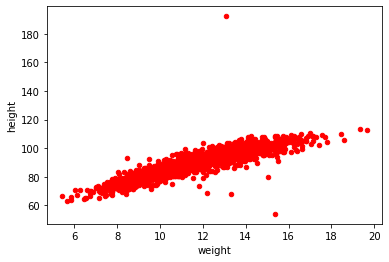

In [16]:
#distribution of weight against height
weight_vs_height = scans.plot.scatter(x='weight', y='height', c='red')

## Analyze outliers: 1) age, 2) weight, 3) height, 4) pixel values

In [17]:
artifacts.describe()

,height,weight,key,age,Years
count,57272.000000,57272.000000,57272.000000,57272.000000,57272.000000
mean,89.965325,11.755754,101.222796,1256.958514,2.941874
std,9.265520,2.195603,4.699983,514.897087,1.381193
min,54.000000,5.450000,100.000000,0.000000,0.000000
25%,83.600000,10.200000,101.000000,966.000000,2.000000
50%,90.600000,11.800000,101.000000,1275.000000,3.000000
75%,96.500000,13.250000,101.000000,1568.000000,4.000000
max,192.200000,19.650000,202.000000,18169.000000,49.000000


### 1) Check age

##### Check age < 6 months or  > 6 years

In [18]:
find_outlier_qrcodes(artifacts, 'age', '<365/2')

['1585014333-santnthviw',
 '1585014363-9iji5fk3z0',
 '1585014369-pohzlgwmj5',
 '1585014399-vypf7yka8r',
 '1585016734-7v4g0jd834',
 '1585119329-nrn8xkjv8h',
 '1585271214-8brq5raxu9',
 '1585271608-y4lv0m7x58',
 '1585273215-crhmfcp509',
 '1585273459-r4dr4i318f',
 '1585273477-nxdc8o8bfi',
 '1585273510-deqcmjslb5',
 '1585273542-bagoat980u',
 '1585273581-kkzed7slcb',
 '1585273724-u6ofjhfyfu',
 '1585350176-71ux4sljgl',
 '1585351186-gu3jkafr22',
 '1585351209-vpbt1ravfb',
 '1585356456-gbib6dyc0k',
 '1585358073-lhg8oycx8w',
 '1585358389-iqmjzadrg8',
 '1585360528-dty9a6gd3a',
 '1585362557-lnbh5rz6qv',
 '1585362994-05a8dzt7db',
 '1585365927-r2gdowfaus',
 '1585014410-ulsr4y63ej',
 '1585014460-d8a367uh2c',
 '1585015663-47cp0jvb3i',
 '1585294285-jkx96y7ojm',
 '1585351282-kauyajspjw',
 '1585348323-y0pjzbft4j',
 '1585355756-o00y4j5eod']

In [19]:
find_outlier_qrcodes(artifacts, 'age', '>365*6')

['1585355880-o0kqvrzncj']

### 2) Check weight

In [20]:
find_outlier_qrcodes(artifacts, 'weight', '<5.0')

[]

In [21]:
find_outlier_qrcodes(artifacts, 'weight', '>30.0')

[]

### 3) Check height

In [22]:
find_outlier_qrcodes(artifacts, 'height', '<40.')

[]

In [23]:
find_outlier_qrcodes(artifacts, 'height', '>150.0')

['1585357787-ko2s9g4cnz']

### 4) Check pixel values

In [24]:
# check for depthmap pixel values < 0 and > 10, values found by MH through investigation
artifacts['path'] = artifacts.apply(get_path, axis=1)
artifacts.head()

,artifact,qrcode,id,height,weight,key,age,Years,path
0,pc_1585004725-18cqo1np0j_1592801845251_100_000.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4,/mnt/datasets/depthmap_testset/scans/158500472...
1,pc_1585004725-18cqo1np0j_1592801845251_100_001.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4,/mnt/datasets/depthmap_testset/scans/158500472...
2,pc_1585004725-18cqo1np0j_1592801845251_100_002.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4,/mnt/datasets/depthmap_testset/scans/158500472...
3,pc_1585004725-18cqo1np0j_1592801845251_100_003.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4,/mnt/datasets/depthmap_testset/scans/158500472...
4,pc_1585004725-18cqo1np0j_1592801845251_100_004.p,1585004725-18cqo1np0j,8KBPkWCDQoxSItFJ_artifact-scan-pcd_15679872000...,96.8,13.65,100,1479,4,/mnt/datasets/depthmap_testset/scans/158500472...


In [25]:
! ls {artifacts.path.iloc[0]}

/mnt/datasets/depthmap_testset/scans/1585004725-18cqo1np0j/100/pc_1585004725-18cqo1np0j_1592801845251_100_000.p


In [ ]:
unusual_pixel_artifacts = []
for path in tqdm(artifacts['path']):
    depthmap, targets = pickle.load(open(path, "rb"))
    max_value = depthmap.max()
    if max_value >= 10:
        unusual_pixel_artifacts.append(path)
        print(f"{path} has a (unexpectedly big) maximal pixel value of {max_value}")
    min_value = depthmap.min()
    if min_value < 0:
        unusual_pixel_artifacts.append(path)
        print(f"{path} has a (unexpectedly small) minimal pixel value of {max_value}")

 15%|█▍        | 8320/57272 [03:57<18:25, 44.27it/s]

In [ ]:
print(len(unusual_pixel_artifacts))
unusual_pixel_artifacts

### Count pickle files

In [ ]:
# Takes approx 5minutes
test_files = glob(str(DATASET_PATH / 'scans/**/*.p'))
len(test_files)

In [ ]:
# files = pd.DataFrame(test_files, columns=['paths'])
# files.to_csv('testing.csv',index=False)